<a href="https://colab.research.google.com/github/rlberry-py/rlberry/blob/main/notebooks/rlberry_evaluate_and_optimize_agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluate an agent and optimize its hyperparameters with `rlberry`

## Colab Setup

In [1]:
# install rlberry library
!git clone https://github.com/rlberry-py/rlberry.git 
!cd rlberry && git pull && pip install -e .[full] > /dev/null 2>&1

# install ffmpeg-python for saving videos
!pip install ffmpeg-python > /dev/null 2>&1

# install optuna for hyperparameter optimization
!pip install optuna > /dev/null 2>&1

# packages required to show video
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

print("")
print(" ~~~  Libraries installed, please restart the runtime! ~~~ ")
print("")


Cloning into 'rlberry'...
remote: Enumerating objects: 5513, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 5513 (delta 54), reused 87 (delta 34), pack-reused 5374
Receiving objects: 100% (5513/5513), 1.29 MiB | 10.98 MiB/s, done.
Resolving deltas: 100% (3759/3759), done.
Already up to date.
^C

 ~~~  Libraries installed, please restart the runtime! ~~~ 



## `AgentStats`: training several instances of an agent

The class `AgentStats` can be used to train several instances of an agent (in parallel), optimize its hyperparameters and analyze its performance.

Check the code below to learn how!

[INFO] OpenGL_accelerate module loaded 
[INFO] Using accelerated ArrayDatatype 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/Grammar.txt 
[INFO] Generating grammar tables from /usr/lib/python3.7/lib2to3/PatternGrammar.txt 
[INFO] Training AgentStats for REINFORCE...  
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 


INFO: Making new env: CartPole-v0


[INFO] [REINFORCE] | episode = 25.000 | ep reward = 13.000 | freq = 54.997 logs/ms 
[INFO] [REINFORCE] | episode = 25.000 | ep reward = 19.000 | freq = 52.192 logs/ms 
[INFO] [REINFORCE] | episode = 50.000 | ep reward = 11.000 | freq = 61.156 logs/ms 
[INFO] [REINFORCE] | episode = 50.000 | ep reward = 26.000 | freq = 42.416 logs/ms 
[INFO] [REINFORCE] | episode = 75.000 | ep reward = 12.000 | freq = 45.628 logs/ms 
[INFO] [REINFORCE] | episode = 75.000 | ep reward = 17.000 | freq = 46.249 logs/ms 
[INFO] [REINFORCE] | episode = 100.000 | ep reward = 19.000 | freq = 44.838 logs/ms 
[INFO] [REINFORCE] | episode = 100.000 | ep reward = 53.000 | freq = 52.381 logs/ms 
[INFO] [REINFORCE] | episode = 125.000 | ep reward = 12.000 | freq = 54.039 logs/ms 
[INFO] [REINFORCE] | episode = 125.000 | ep reward = 9.000 | freq = 45.347 logs/ms 
[INFO] [REINFORCE] | episode = 150.000 | ep reward = 11.000 | freq = 54.056 logs/ms 
[INFO] [REINFORCE] | episode = 150.000 | ep reward = 15.000 | freq = 58.

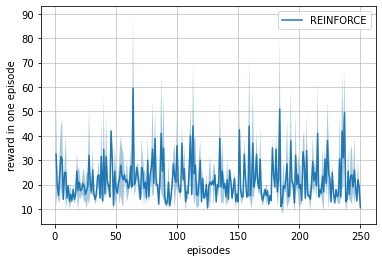

In [1]:
from rlberry.envs import gym_make
from rlberry.agents.torch.reinforce import REINFORCEAgent
from rlberry.stats import AgentStats, plot_writer_data


# Environment
env_ctor = gym_make
env_kwargs = dict(id='CartPole-v0')
env = env_ctor(**env_kwargs)

# Initial set of parameters
params = {"n_episodes": 250,
          "gamma": 0.99,
          "horizon": 200}

# Create AgentStats to fit 4 instances of REINFORCE using 4 threads
stats = AgentStats(REINFORCEAgent,
                   (env_ctor, env_kwargs),
                   init_kwargs=params,
                   n_fit=2,
                   n_jobs=2,
                   joblib_backend='threading')

# Fit the 4 instances
stats.fit()

# The fit() method of REINFORCEAgent writes data to a DefaultWriter (rlberry.utils.writer)
# object, which can be plotted with the method below.
plot_writer_data(stats, tag='episode_rewards')

## `AgentStats`: optimizing hyperparameters

The agent was not able to learn with the previous set of hyperparameters. Let's see if we can make it work by optimizing these parameters!

`REINFORCEAgent` implements a method `sample_hyperparameters`, which allows `AgentStats` to search for the best configuration of hyperparameters. In the class `REINFORCEAgent`, we have:

```python
@classmethod
def sample_parameters(cls, trial):
    """
    Sample hyperparameters for hyperparam optimization using
    Optuna (https://optuna.org/)

    Note: only the kwargs sent to __init__ are optimized. Make sure to
    include in the Agent constructor all "optimizable" parameters.

    Parameters
    ----------
    trial: optuna.trial
    """
    batch_size = trial.suggest_categorical('batch_size', [1, 4, 8, 16, 32])
    gamma = trial.suggest_categorical('gamma', [0.9, 0.95, 0.99])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1)
    entr_coef = trial.suggest_loguniform('entr_coef', 1e-8, 0.1)

    return {
            'batch_size': batch_size,
            'gamma': gamma,
            'learning_rate': learning_rate,
            'entr_coef': entr_coef,
            }
```


[I 2021-03-07 22:11:32,317] A new study created in memory with name: no-name-3fae0e1c-8485-4c48-ba6a-6b5a6c3941b7
[INFO] Could not find least used device (nvidia-smi might be missing), use cuda:0 instead 
[INFO] [REINFORCE] | episode = 25.000 | ep reward = 48.000 | freq = 203.884 logs/ms 
[INFO] [REINFORCE] | episode = 50.000 | ep reward = 33.000 | freq = 175.542 logs/ms 
[INFO] [REINFORCE] | episode = 75.000 | ep reward = 19.000 | freq = 131.223 logs/ms 
[INFO] [REINFORCE] | episode = 100.000 | ep reward = 110.000 | freq = 104.368 logs/ms 
[INFO] [REINFORCE] | episode = 125.000 | ep reward = 191.000 | freq = 59.156 logs/ms 
[INFO] [REINFORCE] | episode = 150.000 | ep reward = 72.000 | freq = 35.568 logs/ms 
[INFO] [REINFORCE] | episode = 175.000 | ep reward = 184.000 | freq = 35.477 logs/ms 
[INFO] [REINFORCE] | episode = 200.000 | ep reward = 179.000 | freq = 26.812 logs/ms 
[INFO] [REINFORCE] | episode = 225.000 | ep reward = 200.000 | freq = 31.711 logs/ms 
[INFO] [REINFORCE] | epi

{'batch_size': 4, 'gamma': 0.95, 'learning_rate': 0.0025625843485706803, 'entr_coef': 6.462259881318044e-08}


[INFO] [REINFORCE] | episode = 25.000 | ep reward = 18.000 | freq = 34.019 logs/ms 
[INFO] [REINFORCE] | episode = 25.000 | ep reward = 43.000 | freq = 29.766 logs/ms 
[INFO] [REINFORCE] | episode = 50.000 | ep reward = 43.000 | freq = 41.015 logs/ms 
[INFO] [REINFORCE] | episode = 50.000 | ep reward = 41.000 | freq = 42.453 logs/ms 
[INFO] [REINFORCE] | episode = 75.000 | ep reward = 45.000 | freq = 38.228 logs/ms 
[INFO] [REINFORCE] | episode = 75.000 | ep reward = 79.000 | freq = 29.035 logs/ms 
[INFO] [REINFORCE] | episode = 100.000 | ep reward = 15.000 | freq = 25.168 logs/ms 
[INFO] [REINFORCE] | episode = 100.000 | ep reward = 72.000 | freq = 19.459 logs/ms 
[INFO] [REINFORCE] | episode = 125.000 | ep reward = 26.000 | freq = 18.414 logs/ms 
[INFO] [REINFORCE] | episode = 125.000 | ep reward = 66.000 | freq = 18.521 logs/ms 
[INFO] [REINFORCE] | episode = 150.000 | ep reward = 48.000 | freq = 17.771 logs/ms 
[INFO] [REINFORCE] | episode = 150.000 | ep reward = 88.000 | freq = 14

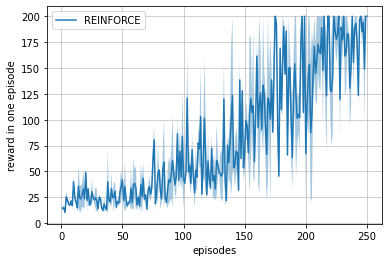

In [2]:
# Run optimization and print results
stats.optimize_hyperparams(
    n_trials=100,
    timeout=120,   # stop after 120 seconds
    n_sim=5,
    n_fit=1,
    n_jobs=1,
    sampler_method='optuna_default',
    disable_evaluation_writers=False
    )

print(stats.best_hyperparams)

# Calling fit() again will train the agent with the optimized parameters
stats.fit()
plot_writer_data(stats, tag='episode_rewards')

In [5]:
# Visualize the agent

import rlberry.colab_utils.display_setup
from rlberry.colab_utils.display_setup import show_video
from gym.wrappers import Monitor

# wrap env
env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)

# take one of the trained agents
agent = stats.fitted_agents[0]

for episode in range(1):
    done = False
    state = env.reset()
    while not done:
        action = agent.policy(state)
        state, reward, done, info = env.step(action)
env.close()
show_video(directory="./gym-results")

INFO: Creating monitor directory ./gym-results
INFO: Starting new video recorder writing to /content/gym-results/openaigym.video.0.2675.video000000.mp4
INFO: Finished writing results. You can upload them to the scoreboard via gym.upload('/content/gym-results')
